Preprocessing du dataset Hippocampus
Objectif: Préparer les données pour l'entraînement du U-Net

In [1]:
import os
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports réussis!")

✅ Imports réussis!


In [2]:
DATASET_PATH = r"C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus"  # À MODIFIER !
IMAGES_TR = os.path.join(DATASET_PATH, "imagesTr")
LABELS_TR = os.path.join(DATASET_PATH, "labelsTr")
DATASET_JSON = os.path.join(DATASET_PATH, "dataset.json")

# Créer dossier pour sauvegarder les données preprocessées
PREPROCESSED_PATH = os.path.join(DATASET_PATH, "preprocessed")
os.makedirs(PREPROCESSED_PATH, exist_ok=True)
os.makedirs(os.path.join(PREPROCESSED_PATH, "train"), exist_ok=True)
os.makedirs(os.path.join(PREPROCESSED_PATH, "val"), exist_ok=True)

print(f"✅ Dossier preprocessed créé: {PREPROCESSED_PATH}")

# Paramètres de preprocessing
TARGET_SIZE = (64, 64, 64)  # Taille cible après cropping/padding
VALIDATION_SPLIT = 0.2      # 20% pour validation
RANDOM_SEED = 42

print(f"\n⚙️ PARAMÈTRES DE PREPROCESSING:")
print(f"  • Taille cible: {TARGET_SIZE}")
print(f"  • Split validation: {VALIDATION_SPLIT * 100}%")
print(f"  • Random seed: {RANDOM_SEED}")

✅ Dossier preprocessed créé: C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus\preprocessed

⚙️ PARAMÈTRES DE PREPROCESSING:
  • Taille cible: (64, 64, 64)
  • Split validation: 20.0%
  • Random seed: 42


Fonctions utilitaires (chargement)

In [3]:
def load_nifti(filepath):
    """Charger un fichier .nii.gz"""
    nifti_img = nib.load(filepath)
    data = nifti_img.get_fdata()
    return data

def filter_valid_nifti(files):
    """Filtrer les fichiers valides (ignorer fichiers système)"""
    return sorted([f for f in files 
                   if f.endswith('.nii.gz') 
                   and not f.startswith('._')
                   and not f.startswith('.')])

# Charger la liste des fichiers
all_images = os.listdir(IMAGES_TR)
all_labels = os.listdir(LABELS_TR)

train_images = filter_valid_nifti(all_images)
train_labels = filter_valid_nifti(all_labels)

print(f"✅ {len(train_images)} fichiers trouvés")

✅ 260 fichiers trouvés


Fonction de normalisation

In [5]:
def normalize_volume(volume, method='zscore'):
    """
    Normaliser un volume 3D
    
    Args:
        volume: numpy array (X, Y, Z)
        method: 'zscore' ou 'minmax'
    
    Returns:
        volume normalisé
    """
    if method == 'zscore':
        # Z-score normalization (recommandé pour IRM)
        mean = np.mean(volume)
        std = np.std(volume)
        if std > 0:
            normalized = (volume - mean) / std
        else:
            normalized = volume - mean
            
    elif method == 'minmax':
        # Min-Max normalization [0, 1]
        min_val = np.min(volume)
        max_val = np.max(volume)
        if max_val > min_val:
            normalized = (volume - min_val) / (max_val - min_val)
        else:
            normalized = np.zeros_like(volume)
    
    else:
        raise ValueError(f"Méthode inconnue: {method}")
    
    return normalized.astype(np.float32)


# Test de normalisation
print("🧪 Test de normalisation:")
test_volume = np.random.randn(10, 10, 10) * 100 + 500
normalized = normalize_volume(test_volume, method='zscore')

print(f"  Volume original: mean={np.mean(test_volume):.2f}, std={np.std(test_volume):.2f}")
print(f"  Volume normalisé: mean={np.mean(normalized):.2e}, std={np.std(normalized):.2f}")
print(f"✅ Normalisation fonctionne!")

🧪 Test de normalisation:
  Volume original: mean=499.25, std=95.33
  Volume normalisé: mean=-5.72e-09, std=1.00
✅ Normalisation fonctionne!


Fonction de cropping/padding intelligent

In [6]:
def crop_or_pad_to_size(volume, target_size):
    """
    Crop ou pad un volume pour atteindre target_size
    Le cropping est centré sur le centre du volume
    
    Args:
        volume: numpy array (X, Y, Z)
        target_size: tuple (target_X, target_Y, target_Z)
    
    Returns:
        volume de taille target_size
    """
    current_size = volume.shape
    output = np.zeros(target_size, dtype=volume.dtype)
    
    # Calculer les indices de début pour centrer le crop/pad
    starts_input = []
    starts_output = []
    
    for i in range(3):
        if current_size[i] >= target_size[i]:
            # Crop: prendre le centre
            start_input = (current_size[i] - target_size[i]) // 2
            start_output = 0
            size = target_size[i]
        else:
            # Pad: centrer dans output
            start_input = 0
            start_output = (target_size[i] - current_size[i]) // 2
            size = current_size[i]
        
        starts_input.append(start_input)
        starts_output.append(start_output)
    
    # Copier les données
    output[
        starts_output[0]:starts_output[0] + min(current_size[0], target_size[0]),
        starts_output[1]:starts_output[1] + min(current_size[1], target_size[1]),
        starts_output[2]:starts_output[2] + min(current_size[2], target_size[2])
    ] = volume[
        starts_input[0]:starts_input[0] + min(current_size[0], target_size[0]),
        starts_input[1]:starts_input[1] + min(current_size[1], target_size[1]),
        starts_input[2]:starts_input[2] + min(current_size[2], target_size[2])
    ]
    
    return output


# Test
print("🧪 Test de crop/pad:")
test_small = np.ones((30, 30, 30))
test_large = np.ones((100, 100, 100))

result_small = crop_or_pad_to_size(test_small, TARGET_SIZE)
result_large = crop_or_pad_to_size(test_large, TARGET_SIZE)

print(f"  Petit volume (30,30,30) → {result_small.shape}")
print(f"  Grand volume (100,100,100) → {result_large.shape}")
print(f"✅ Crop/Pad fonctionne!")

🧪 Test de crop/pad:
  Petit volume (30,30,30) → (64, 64, 64)
  Grand volume (100,100,100) → (64, 64, 64)
✅ Crop/Pad fonctionne!


Pipeline de preprocessing : charger → normaliser → crop/pad

In [7]:
def preprocess_volume(image_path, label_path, target_size, normalize_method='zscore'):
    """
    Preprocessing complet d'un volume et son label
    
    Args:
        image_path: chemin vers l'image .nii.gz
        label_path: chemin vers le label .nii.gz
        target_size: tuple (X, Y, Z)
        normalize_method: 'zscore' ou 'minmax'
    
    Returns:
        image_processed, label_processed
    """
    # Charger
    image = load_nifti(image_path)
    label = load_nifti(label_path)
    
    # Normaliser l'image (PAS le label!)
    image_normalized = normalize_volume(image, method=normalize_method)
    
    # Crop/Pad
    image_resized = crop_or_pad_to_size(image_normalized, target_size)
    label_resized = crop_or_pad_to_size(label, target_size)
    
    # Convertir label en entiers
    label_resized = label_resized.astype(np.int64)
    
    return image_resized, label_resized


# Test sur un exemple
print("🧪 Test du pipeline complet:")
test_img_path = os.path.join(IMAGES_TR, train_images[0])
test_lbl_path = os.path.join(LABELS_TR, train_labels[0])

img_proc, lbl_proc = preprocess_volume(test_img_path, test_lbl_path, TARGET_SIZE)

print(f"  Image preprocessée: shape={img_proc.shape}, dtype={img_proc.dtype}")
print(f"  Label preprocessé: shape={lbl_proc.shape}, dtype={lbl_proc.dtype}")
print(f"  Valeurs uniques dans label: {np.unique(lbl_proc)}")
print(f"✅ Pipeline complet fonctionne!")

🧪 Test du pipeline complet:
  Image preprocessée: shape=(64, 64, 64), dtype=float32
  Label preprocessé: shape=(64, 64, 64), dtype=int64
  Valeurs uniques dans label: [0 1 2]
✅ Pipeline complet fonctionne!


Split train/validation

In [8]:
np.random.seed(RANDOM_SEED)

# Créer les paires image-label
pairs = list(zip(train_images, train_labels))

# Split
train_pairs, val_pairs = train_test_split(
    pairs, 
    test_size=VALIDATION_SPLIT, 
    random_state=RANDOM_SEED
)

print(f"📊 SPLIT DU DATASET:")
print(f"  Total: {len(pairs)} volumes")
print(f"  Train: {len(train_pairs)} volumes ({(1-VALIDATION_SPLIT)*100:.0f}%)")
print(f"  Validation: {len(val_pairs)} volumes ({VALIDATION_SPLIT*100:.0f}%)")

# Sauvegarder les splits
split_info = {
    'train': [{'image': img, 'label': lbl} for img, lbl in train_pairs],
    'val': [{'image': img, 'label': lbl} for img, lbl in val_pairs],
    'target_size': TARGET_SIZE,
    'normalization': 'zscore'
}

split_file = os.path.join(PREPROCESSED_PATH, 'split_info.json')
with open(split_file, 'w') as f:
    json.dump(split_info, f, indent=2)

print(f"✅ Split info sauvegardé: {split_file}")

📊 SPLIT DU DATASET:
  Total: 260 volumes
  Train: 208 volumes (80%)
  Validation: 52 volumes (20%)
✅ Split info sauvegardé: C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus\preprocessed\split_info.json


Preprocessing de TOUS les volumes

In [10]:
print("PREPROCESSING DE TOUS LES VOLUMES")
print("=" * 60)
print()

def preprocess_and_save(pairs, split_name):
    """Preprocesser et sauvegarder un split"""
    for i, (img_file, lbl_file) in enumerate(pairs):
        try:
            # Chemins
            img_path = os.path.join(IMAGES_TR, img_file)
            lbl_path = os.path.join(LABELS_TR, lbl_file)
            
            # Preprocessing
            img_proc, lbl_proc = preprocess_volume(img_path, lbl_path, TARGET_SIZE)
            
            # Sauvegarder (format .npy pour chargement rapide)
            base_name = img_file.replace('.nii.gz', '')
            
            save_img_path = os.path.join(PREPROCESSED_PATH, split_name, f"{base_name}_img.npy")
            save_lbl_path = os.path.join(PREPROCESSED_PATH, split_name, f"{base_name}_lbl.npy")
            
            np.save(save_img_path, img_proc)
            np.save(save_lbl_path, lbl_proc)
            
            # Afficher progression
            if (i + 1) % 10 == 0 or (i + 1) == len(pairs):
                print(f"  [{split_name}] {i+1}/{len(pairs)} volumes traités...")
        
        except Exception as e:
            print(f"  ❌ Erreur avec {img_file}: {str(e)}")
            continue

# Preprocesser train
print(" Preprocessing TRAIN set...")
preprocess_and_save(train_pairs, 'train')

# Preprocesser validation
print("\n Preprocessing VALIDATION set...")
preprocess_and_save(val_pairs, 'val')

print("\n" + "=" * 60)
print("✅ PREPROCESSING TERMINÉ!")
print(f"📁 Fichiers sauvegardés dans: {PREPROCESSED_PATH}")


PREPROCESSING DE TOUS LES VOLUMES

 Preprocessing TRAIN set...
  [train] 10/208 volumes traités...
  [train] 20/208 volumes traités...
  [train] 30/208 volumes traités...
  [train] 40/208 volumes traités...
  [train] 50/208 volumes traités...
  [train] 60/208 volumes traités...
  [train] 70/208 volumes traités...
  [train] 80/208 volumes traités...
  [train] 90/208 volumes traités...
  [train] 100/208 volumes traités...
  [train] 110/208 volumes traités...
  [train] 120/208 volumes traités...
  [train] 130/208 volumes traités...
  [train] 140/208 volumes traités...
  [train] 150/208 volumes traités...
  [train] 160/208 volumes traités...
  [train] 170/208 volumes traités...
  [train] 180/208 volumes traités...
  [train] 190/208 volumes traités...
  [train] 200/208 volumes traités...
  [train] 208/208 volumes traités...

 Preprocessing VALIDATION set...
  [val] 10/52 volumes traités...
  [val] 20/52 volumes traités...
  [val] 30/52 volumes traités...
  [val] 40/52 volumes traités...
  [

Vérification du preprocessing

In [11]:
print("🔍 VÉRIFICATION DU PREPROCESSING")
print("=" * 60)

# Compter les fichiers
train_files = [f for f in os.listdir(os.path.join(PREPROCESSED_PATH, 'train')) if f.endswith('_img.npy')]
val_files = [f for f in os.listdir(os.path.join(PREPROCESSED_PATH, 'val')) if f.endswith('_img.npy')]

print(f"Fichiers train: {len(train_files)}")
print(f"Fichiers val: {len(val_files)}")

# Charger un exemple
if len(train_files) > 0:
    sample_img_path = os.path.join(PREPROCESSED_PATH, 'train', train_files[0])
    sample_lbl_path = sample_img_path.replace('_img.npy', '_lbl.npy')
    
    sample_img = np.load(sample_img_path)
    sample_lbl = np.load(sample_lbl_path)
    
    print(f"\n📋 Exemple de fichier preprocessé:")
    print(f"  Image shape: {sample_img.shape}")
    print(f"  Image dtype: {sample_img.dtype}")
    print(f"  Image range: [{sample_img.min():.2f}, {sample_img.max():.2f}]")
    print(f"  Label shape: {sample_lbl.shape}")
    print(f"  Label dtype: {sample_lbl.dtype}")
    print(f"  Label classes: {np.unique(sample_lbl)}")
    
    print("\n✅ Preprocessing vérifié avec succès!")
else:
    print("❌ Aucun fichier preprocessed trouvé!")

🔍 VÉRIFICATION DU PREPROCESSING
Fichiers train: 208
Fichiers val: 52

📋 Exemple de fichier preprocessé:
  Image shape: (64, 64, 64)
  Image dtype: float32
  Image range: [-2.46, 3.02]
  Label shape: (64, 64, 64)
  Label dtype: int64
  Label classes: [0 1 2]

✅ Preprocessing vérifié avec succès!


Visualisation avant/après preprocessing

VISUALISATION AVANT/APRÈS


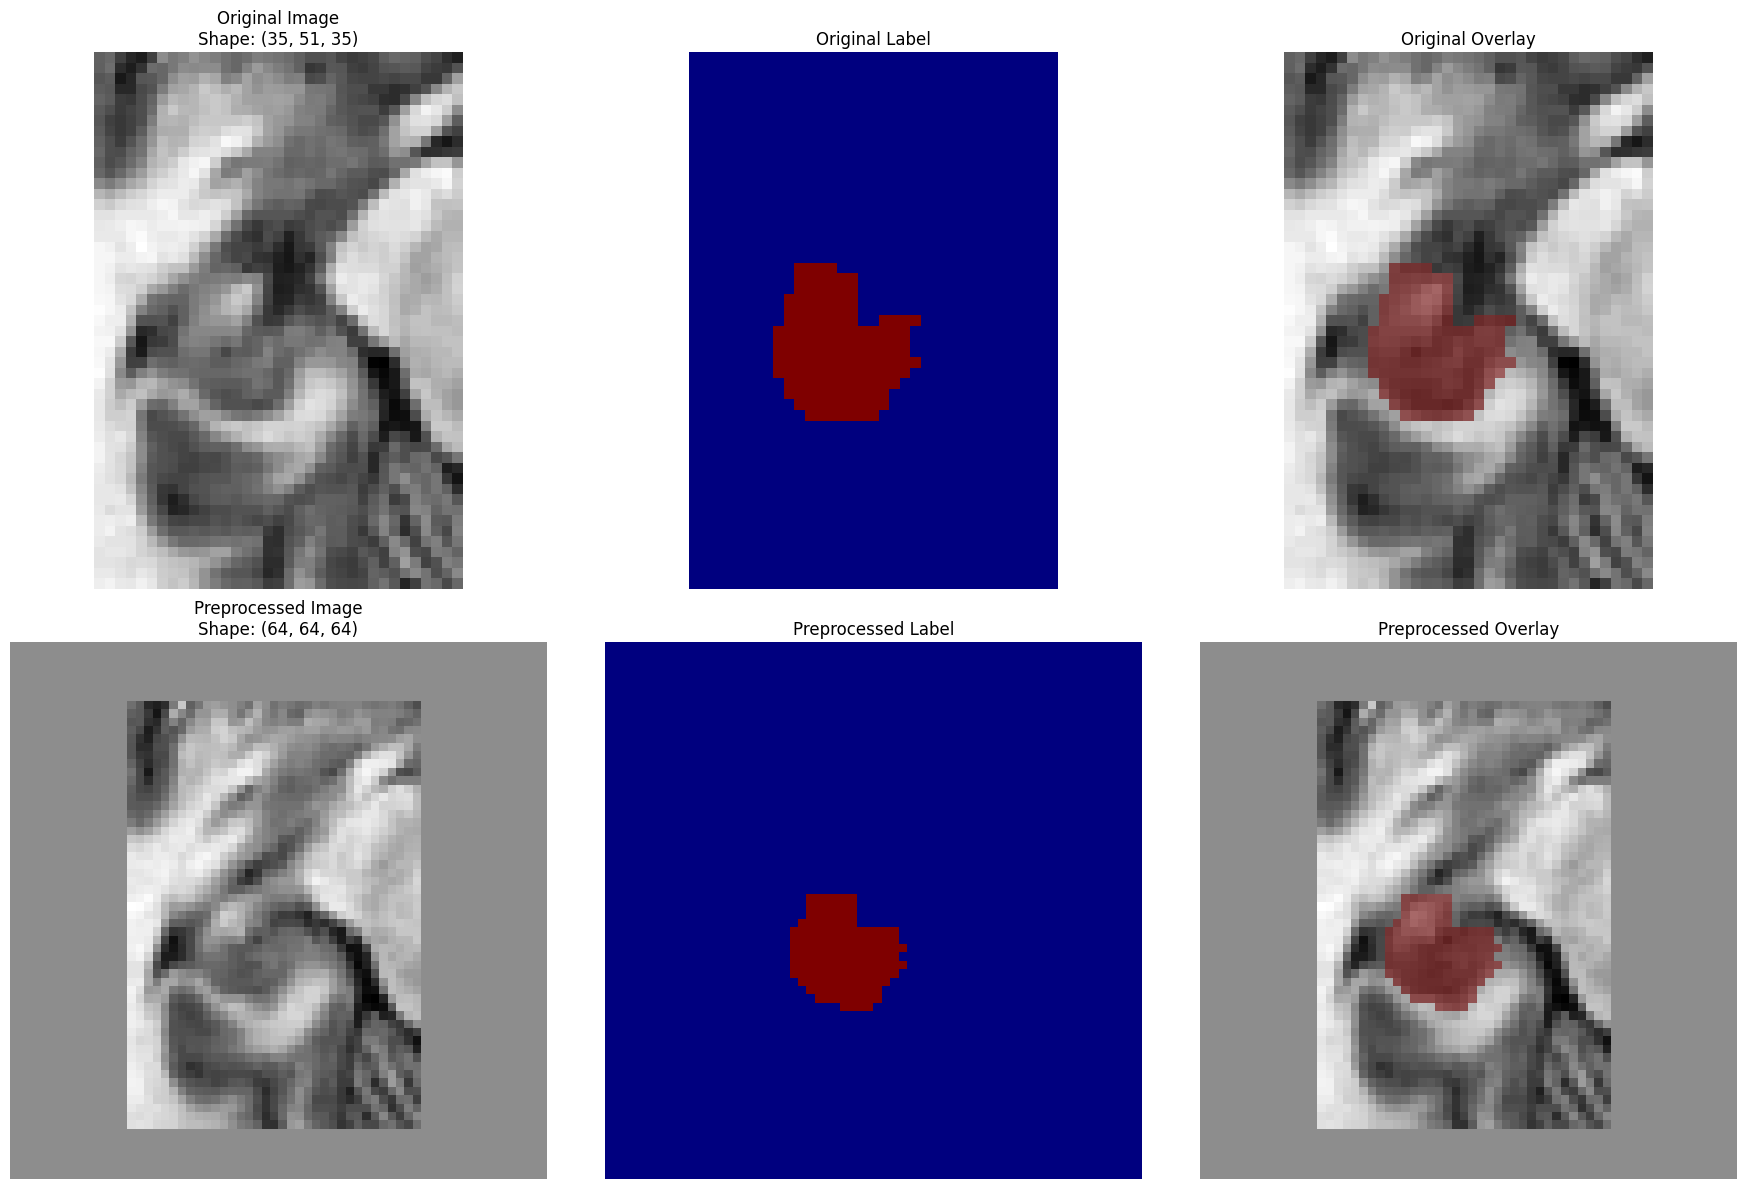

✅ Graphique sauvegardé: preprocessing_comparison.png


In [12]:
print("VISUALISATION AVANT/APRÈS")
print("=" * 60)

# Charger volume original
orig_img_path = os.path.join(IMAGES_TR, train_images[0])
orig_lbl_path = os.path.join(LABELS_TR, train_labels[0])
orig_img = load_nifti(orig_img_path)
orig_lbl = load_nifti(orig_lbl_path)

# Charger volume preprocessed
prep_img_path = os.path.join(PREPROCESSED_PATH, 'train', train_files[0])
prep_lbl_path = prep_img_path.replace('_img.npy', '_lbl.npy')
prep_img = np.load(prep_img_path)
prep_lbl = np.load(prep_lbl_path)

# Visualisation
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Ligne 1: Original
slice_orig = orig_img.shape[2] // 2
axes[0, 0].imshow(orig_img[:, :, slice_orig].T, cmap='gray', origin='lower')
axes[0, 0].set_title(f'Original Image\nShape: {orig_img.shape}')
axes[0, 0].axis('off')

axes[0, 1].imshow(orig_lbl[:, :, slice_orig].T, cmap='jet', origin='lower', vmin=0, vmax=2)
axes[0, 1].set_title(f'Original Label')
axes[0, 1].axis('off')

axes[0, 2].imshow(orig_img[:, :, slice_orig].T, cmap='gray', origin='lower')
mask_orig = orig_lbl[:, :, slice_orig].T > 0
axes[0, 2].imshow(np.ma.masked_where(~mask_orig, orig_lbl[:, :, slice_orig].T), 
                  cmap='jet', alpha=0.5, origin='lower', vmin=0, vmax=2)
axes[0, 2].set_title('Original Overlay')
axes[0, 2].axis('off')

# Ligne 2: Preprocessed
slice_prep = prep_img.shape[2] // 2
axes[1, 0].imshow(prep_img[:, :, slice_prep].T, cmap='gray', origin='lower')
axes[1, 0].set_title(f'Preprocessed Image\nShape: {prep_img.shape}')
axes[1, 0].axis('off')

axes[1, 1].imshow(prep_lbl[:, :, slice_prep].T, cmap='jet', origin='lower', vmin=0, vmax=2)
axes[1, 1].set_title(f'Preprocessed Label')
axes[1, 1].axis('off')

axes[1, 2].imshow(prep_img[:, :, slice_prep].T, cmap='gray', origin='lower')
mask_prep = prep_lbl[:, :, slice_prep].T > 0
axes[1, 2].imshow(np.ma.masked_where(~mask_prep, prep_lbl[:, :, slice_prep].T), 
                  cmap='jet', alpha=0.5, origin='lower', vmin=0, vmax=2)
axes[1, 2].set_title('Preprocessed Overlay')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('preprocessing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: preprocessing_comparison.png")

Statistiques finales

In [14]:
print("\n" + "=" * 60)
print(" STATISTIQUES FINALES")
print("=" * 60)

# Analyser quelques volumes preprocessed
stats = {'train': [], 'val': []}

for split in ['train', 'val']:
    files = [f for f in os.listdir(os.path.join(PREPROCESSED_PATH, split)) if f.endswith('_img.npy')]
    
    for f in files[:10]:  # Analyser 10 fichiers par split
        img_path = os.path.join(PREPROCESSED_PATH, split, f)
        img = np.load(img_path)
        
        stats[split].append({
            'mean': np.mean(img),
            'std': np.std(img),
            'min': np.min(img),
            'max': np.max(img)
        })

# Afficher
for split in ['train', 'val']:
    if len(stats[split]) > 0:
        means = [s['mean'] for s in stats[split]]
        stds = [s['std'] for s in stats[split]]
        
        print(f"\n{split.upper()} set (échantillon de {len(stats[split])} volumes):")
        print(f"  Mean: {np.mean(means):.4f} ± {np.std(means):.4f}")
        print(f"  Std:  {np.mean(stds):.4f} ± {np.std(stds):.4f}")

print("\n" + "=" * 60)
print(" PREPROCESSING COMPLET TERMINÉ!")
print("\n RÉSUMÉ:")
print(f"  • {len(train_files)} volumes d'entraînement")
print(f"  • {len(val_files)} volumes de validation")
print(f"  • Taille uniforme: {TARGET_SIZE}")
print(f"  • Normalisation: z-score")
print(f"  • Format: .npy (numpy arrays)")
print(f"\n Prêt pour l'entraînement du U-Net!")
print("=" * 60)



 STATISTIQUES FINALES

TRAIN set (échantillon de 10 volumes):
  Mean: -0.0000 ± 0.0000
  Std:  0.5021 ± 0.0207

VAL set (échantillon de 10 volumes):
  Mean: 0.0000 ± 0.0000
  Std:  0.4911 ± 0.0201

 PREPROCESSING COMPLET TERMINÉ!

 RÉSUMÉ:
  • 208 volumes d'entraînement
  • 52 volumes de validation
  • Taille uniforme: (64, 64, 64)
  • Normalisation: z-score
  • Format: .npy (numpy arrays)

 Prêt pour l'entraînement du U-Net!


Data Augmentation - Définition des fonctions

In [15]:
import scipy.ndimage as ndi

def random_flip_3d(image, label, axes=[0, 1, 2]):
    """Flip aléatoire selon un ou plusieurs axes"""
    for axis in axes:
        if np.random.rand() > 0.5:
            image = np.flip(image, axis=axis)
            label = np.flip(label, axis=axis)
    return image.copy(), label.copy()

def random_rotation_3d(image, label, angle_range=(-15, 15)):
    """Rotation aléatoire (en degrés)"""
    angle = np.random.uniform(angle_range[0], angle_range[1])
    
    # Rotation autour de l'axe Z
    image_rot = ndi.rotate(image, angle, axes=(0, 1), reshape=False, order=1)
    label_rot = ndi.rotate(label, angle, axes=(0, 1), reshape=False, order=0)
    
    return image_rot, label_rot

def random_noise(image, noise_variance=0.01):
    """Ajouter du bruit gaussien"""
    noise = np.random.normal(0, noise_variance, image.shape)
    return image + noise

def random_intensity_shift(image, shift_range=(-0.1, 0.1)):
    """Décalage d'intensité aléatoire"""
    shift = np.random.uniform(shift_range[0], shift_range[1])
    return image + shift

def augment_volume(image, label):
    """
    Pipeline d'augmentation complet
    Appliqué aléatoirement pendant l'entraînement
    """
    # Flip (50% de chance)
    if np.random.rand() > 0.5:
        image, label = random_flip_3d(image, label, axes=[0, 1])
    
    # Rotation (30% de chance)
    if np.random.rand() > 0.7:
        image, label = random_rotation_3d(image, label, angle_range=(-10, 10))
    
    # Bruit (30% de chance)
    if np.random.rand() > 0.7:
        image = random_noise(image, noise_variance=0.01)
    
    # Shift d'intensité (30% de chance)
    if np.random.rand() > 0.7:
        image = random_intensity_shift(image, shift_range=(-0.1, 0.1))
    
    return image, label


# Test d'augmentation
print(" Test des augmentations:")
test_img = np.random.randn(64, 64, 64)
test_lbl = np.random.randint(0, 3, (64, 64, 64))

aug_img, aug_lbl = augment_volume(test_img, test_lbl)

print(f"  Image augmentée: shape={aug_img.shape}")
print(f"  Label augmenté: shape={aug_lbl.shape}")
print(f"✅ Augmentations définies!")

 Test des augmentations:
  Image augmentée: shape=(64, 64, 64)
  Label augmenté: shape=(64, 64, 64)
✅ Augmentations définies!
